In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from collections import Counter
import pickle
from tensorflow.keras.layers import Embedding,LSTM,Dropout,BatchNormalization,GlobalMaxPooling1D,Dense,Input,Flatten,TimeDistributed
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from hazm import *
import string
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GRU

In [2]:
df=pd.read_csv('train.csv',low_memory=False)
df1=pd.read_csv('test.csv',low_memory=False)

In [3]:
df

,id,comment,product_id,product_title_fa,category_id,category_title_fa,is_buyer,price_value,fake_originality,warranty,size,discrepancy,flavor_odor,expiration_date
0,1215666.0,ارزششو داشت,2802959,جوراب مردانه فیرو پلاس مدل FP200 مجموعه 4 عددی,9456,جوراب و ساق مردانه,TRUE,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1183149.0,یه دستگاه کاربردی فقط ای کاش طرز استفادشو میزد...,1894596,دستگاه سفید کننده دندان دنتال وایت مدل DT-1244,5745,مسواک برقی,TRUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1011730.0,خیلی خوب و ارزان,323729,کتاب بهترین قصه ملانصرالدین کلک مرغابی اثر مهر...,5918,کتاب چاپی,TRUE,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1093325.0,اندازش خیلیییییی بزرگ بود,1431242,نوار بهداشتی تافته مدل Thin بسته 7 عددی,6528,نوار بهداشتی,TRUE,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1111983.0,خیلی بد بود و میچسبید به دست,1902220,ژل بازی کد shb57,6083,ابزار شوخی,FALSE,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179994,1113909.0,خیلی خوب بود و کاربردی,451814,جای کاغذ یادداشت رایدین مدل طلقی به همراه یک ب...,6014,لوازم اداری رومیزی,TRUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179995,1100949.0,+ممنون از فروشنده+\r\n+ممنون از دیجی کالا+,791984,دوشاخه برق الکتروفراز کد 003,1289,چندراهی برق و محافظ ولتاژ,TRUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179996,1161446.0,ماست خوشمزه و با کیفیت,1578085,ماست گلدن پاک - 2.5 کیلوگرم,9216,ماست,TRUE,0.0,0.0,0.0,0.0,0.0,1.0,0.0
179997,1057088.0,به قیمتش می ارزه . خوشگل,1781940,گیره مو کد PK272,9398,اکسسوری مو زنانه,TRUE,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df['is_buyer'].replace('TRUE',True,inplace=True)
df['is_buyer'].replace('FALSE',False,inplace=True)
df.dropna(inplace=True)

In [5]:
df.reset_index(inplace=True)
df['is_buyer'] =df['is_buyer'].map({True:1,False:0})
df1['is_buyer'] =df1['is_buyer'].map({True:1,False:0})
df1.is_buyer.unique()

array([1, 0], dtype=int64)

In [6]:
df['is_buyer'].value_counts()

1    171251
0      8743
Name: is_buyer, dtype: int64

In [7]:
df_train=df.drop(columns=['index','id','product_id','category_id'])
df_test=df1.drop(columns=['id','product_id','category_id'])

In [8]:
df_train["text"] = df_train['comment']
df_test["text"] = df_test['comment']

In [9]:
df_train['length'] = df_train['text'].apply(lambda x: len(x))
df_test['length'] = df_test['text'].apply(lambda x: len(x))

In [10]:
df_train.drop(columns=['comment','category_title_fa','product_title_fa'],inplace=True)
df_test.drop(columns=['comment','category_title_fa','product_title_fa'],inplace=True)

In [11]:
def normalizeing(text):
    normalizer = Normalizer()
    return normalizer.normalize(text)
df_train['text'] = df_train['text'].apply(lambda x: normalizeing(x))
df_test['text'] = df_test['text'].apply(lambda x: normalizeing(x))

In [12]:
def convert_to_lower(text):
    return text.lower()
df_train['text'] = df_train['text'].apply(lambda x: convert_to_lower(x))
df_test['text'] = df_test['text'].apply(lambda x: convert_to_lower(x))

In [13]:
def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number
df_train['text'] = df_train['text'].apply(lambda x: remove_numbers(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_numbers(x))

In [14]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))
df_train['text'] = df_train['text'].apply(lambda x: remove_punctuation(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_punctuation(x))

In [15]:
with open('stopwords.txt',encoding='utf-8') as stopwords_file:
    stopwords=stopwords_file.readlines()
stopwords=[line.replace('\n','') for line in stopwords]
import nltk
nltk.download('stopwords')
nltk_stopwords=nltk.corpus.stopwords.words('english')
stopwords.extend(nltk_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aghil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def remove_stopwords(text):
    removed = []
    stop_words = stopwords
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)
df_train['text'] = df_train['text'].apply(lambda x: remove_stopwords(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_stopwords(x))

In [17]:
def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z0-9آ-ی۰-۹]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc
df_train['text'] = df_train['text'].apply(lambda x: remove_extra_white_spaces(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_extra_white_spaces(x))

In [18]:
def stemmering(text):
    stemmer = Stemmer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = stemmer.stem(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)
df_train['text'] = df_train['text'].apply(lambda x: stemmering(x))
df_test['text'] = df_test['text'].apply(lambda x: stemmering(x))

In [19]:
df_train['length_after_cleaning'] = df_train['text'].apply(lambda x: len(x))
df_test['length_after_cleaning'] = df_test['text'].apply(lambda x: len(x))

In [20]:
df_test.head()

,is_buyer,text,length,length_after_cleaning
0,1,معمولیه کیفیت,56,13
1,1,پول می‌ارزه,36,11
2,1,ای بدک,14,6
3,1,خوبه قیم,38,8
4,1,ظریف,15,4


In [21]:
df_train.head()

,is_buyer,price_value,fake_originality,warranty,size,discrepancy,flavor_odor,expiration_date,text,length,length_after_cleaning
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ارزششو,11,6
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,دستگاه کاربرد طرز استفادشو میزد اینقد نباش,76,42
2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ارز,16,3
3,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,انداز خیلییی,25,12
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,میچسبید دس,28,10


In [22]:
df_train['powerlabel'] = np.array(df_train.apply(lambda x : 64*x["price_value"]+32*x['fake_originality']+
                                       16*x['warranty']+8*x['size']+
                                       4*x['discrepancy']+2*x['flavor_odor']+
                                       1*x['expiration_date'],axis=1))

In [23]:
from sklearn.preprocessing import OneHotEncoder

In [24]:
ohe=OneHotEncoder()

In [38]:
x=ohe.fit_transform(np.array(df_train.powerlabel).reshape(-1,1))
x.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
label=x.toarray()

In [40]:
buy=np.array(df_train['is_buyer'])
len(buy)

179994

In [41]:
buy_test=np.array(df_test['is_buyer'])
len(buy_test)

44131

In [42]:
# Define the sequence lengths, max number of words and embedding dimensions
MAX_SEQUENCE_LENGTH = 35 #can plot a graph for length
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 200


In [43]:
# Get the frequently occurring words
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_train.text.astype(str))
train_sequences = tokenizer.texts_to_sequences(df_train.text.astype(str))
test_sequences = tokenizer.texts_to_sequences(df_test.text.astype(str))
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

for i in range(len(buy)):
    if buy[i]==1:
        train_sequences[i].append(41701)
    else: train_sequences[i].append(41702)
for i in range(len(buy_test)):
    if buy[i]==1:
        test_sequences[i].append(41701)
    else: test_sequences[i].append(41702)
    
#some padding shit
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post',
    truncating='post')
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post',
    truncating='post')

Found 41620 unique tokens.


In [44]:
label_data=df_train[['price_value', 'fake_originality', 'warranty', 'size','discrepancy', 'flavor_odor', 'expiration_date']]

In [45]:
class_names=['price_value', 'fake_originality', 'warranty', 'size','discrepancy', 'flavor_odor', 'expiration_date']

In [46]:
class_weights = {}
positive_weights = {}
negative_weights = {}

for label in (class_names):
    positive_weights[label] = df_train.shape[0] /(2 * np.count_nonzero(df_train[label] == 1))
    negative_weights[label] = df_train.shape[0] /(2 * np.count_nonzero(df_train[label] == 0))
    
class_weights['positive_weights'] = positive_weights
class_weights['negative_weights'] = negative_weights
class_weights

{'positive_weights': {'price_value': 2.5185257737728772,
  'fake_originality': 71.3695479777954,
  'warranty': 229.5841836734694,
  'size': 6.168825827678388,
  'discrepancy': 11.748955613577024,
  'flavor_odor': 9.91702479338843,
  'expiration_date': 169.16729323308272},
 'negative_weights': {'price_value': 0.6238527658394566,
  'fake_originality': 0.5035276082200825,
  'warranty': 0.5010913018785982,
  'size': 0.5441008433844201,
  'discrepancy': 0.5222242853992828,
  'flavor_odor': 0.5265476629280537,
  'expiration_date': 0.5014822079325986}}

In [47]:
class_weights1={'positive_weights': {'price_value': 1.0178571428571428,
  'fake_originality': 1.2391304347826086,
  'warranty': 2.375,
  'size': 1.3571428571428572,
  'discrepancy': 1.2954545454545454,
  'flavor_odor': 1.3571428571428572,
  'expiration_date': 1.78125},
 'negative_weights': {'price_value': 0.9827586206896551,
  'fake_originality': 0.8382352941176471,
  'warranty': 0.6333333333333333,
  'size': 0.7916666666666666,
  'discrepancy': 0.8142857142857143,
  'flavor_odor': 0.7916666666666666,
  'expiration_date': 0.6951219512195121}}
Wp = class_weights1['positive_weights']
Wn = class_weights1['negative_weights']

def custom_loss(y_true, y_logit):
    loss = float(0)
    
    for i, key in enumerate(Wp.keys()):
        first_term = Wp[key] * y_true[i] * K.log(y_logit[i] + K.epsilon())
        second_term = Wn[key] * (1 - y_true[i]) * K.log(1 - y_logit[i] + K.epsilon())
        loss -= (first_term + second_term)
    return loss

In [48]:
def f1_score(y_true, y_logit):
    true_positives = K.sum(K.round(K.clip(y_true * y_logit, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    predicted_positives = K.sum(K.round(K.clip(y_logit, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return (2 * precision * recall) / (precision + recall + K.epsilon())

In [55]:
label=x.toarray()

In [56]:
label

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
in1=Input(shape=(MAX_SEQUENCE_LENGTH))
x=Embedding(MAX_NB_WORDS,100)(in1)
x=LSTM(64,return_sequences=True)(x)
x=LSTM(32,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
#x=Dense(50,activation='relu')(x)
#x=Dense(20,activation='relu')(x)
x=Dense(10,activation='relu')(x)
out=Dense(57,activation='sigmoid')(x)

In [58]:
model = Model(inputs=in1, outputs=out)

In [59]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 35)]              0         
                                                                 
 embedding (Embedding)       (None, 35, 100)           2000000   
                                                                 
 lstm (LSTM)                 (None, 35, 64)            42240     
                                                                 
 lstm_1 (LSTM)               (None, 35, 32)            12416     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                330       
                                                             

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

pat=EarlyStopping(patience=5)

In [61]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=custom_loss, metrics=['accuracy',f1_score])

In [62]:

history = model.fit(
    train_data, np.array(label), batch_size=512, epochs=50, validation_split=0.3,callbacks=[pat])

Epoch 1/50
247/247 [==============================] - 16s 35ms/step - loss: 3.5039 - accuracy: 0.6474 - f1_score: 0.0888 - val_loss: 2.9615 - val_accuracy: 0.6516 - val_f1_score: 0.1180
Epoch 2/50
247/247 [==============================] - 7s 30ms/step - loss: 2.4002 - accuracy: 0.6495 - f1_score: 0.1641 - val_loss: 1.8147 - val_accuracy: 0.6516 - val_f1_score: 0.2174
Epoch 3/50
247/247 [==============================] - 7s 30ms/step - loss: 1.4434 - accuracy: 0.6495 - f1_score: 0.3992 - val_loss: 1.1055 - val_accuracy: 0.6516 - val_f1_score: 0.4345
Epoch 4/50
247/247 [==============================] - 7s 30ms/step - loss: 0.9017 - accuracy: 0.6495 - f1_score: 0.5291 - val_loss: 0.7139 - val_accuracy: 0.6516 - val_f1_score: 0.6518
Epoch 5/50
247/247 [==============================] - 8s 31ms/step - loss: 0.6118 - accuracy: 0.6495 - f1_score: 0.6496 - val_loss: 0.5041 - val_accuracy: 0.6516 - val_f1_score: 0.6518
Epoch 6/50
247/247 [==============================] - 8s 32ms/step - loss:

247/247 [==============================] - 8s 31ms/step - loss: 0.2039 - accuracy: 0.6624 - f1_score: 0.6873 - val_loss: 0.1974 - val_accuracy: 0.6680 - val_f1_score: 0.7015
Epoch 46/50
247/247 [==============================] - 8s 31ms/step - loss: 0.2129 - accuracy: 0.6680 - f1_score: 0.7003 - val_loss: 0.1967 - val_accuracy: 0.6777 - val_f1_score: 0.7123
Epoch 47/50
247/247 [==============================] - 8s 32ms/step - loss: 0.2045 - accuracy: 0.6767 - f1_score: 0.7059 - val_loss: 0.1940 - val_accuracy: 0.6902 - val_f1_score: 0.7134
Epoch 48/50
247/247 [==============================] - 9s 37ms/step - loss: 0.2004 - accuracy: 0.6872 - f1_score: 0.7095 - val_loss: 0.1922 - val_accuracy: 0.6902 - val_f1_score: 0.7115
Epoch 49/50
247/247 [==============================] - 8s 33ms/step - loss: 0.1948 - accuracy: 0.6866 - f1_score: 0.7113 - val_loss: 0.1898 - val_accuracy: 0.6836 - val_f1_score: 0.7107
Epoch 50/50
247/247 [==============================] - 8s 31ms/step - loss: 0.2033

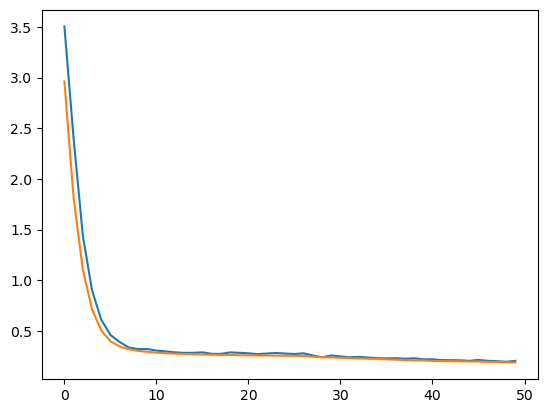

In [114]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

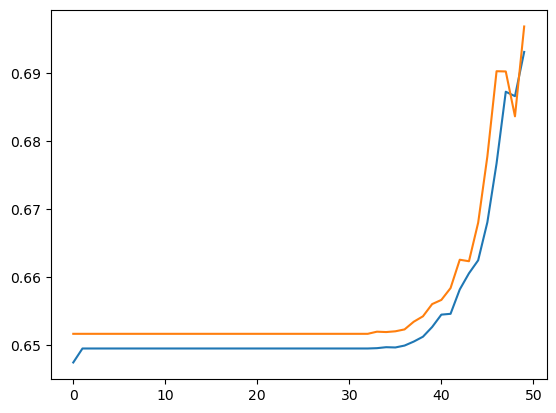

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

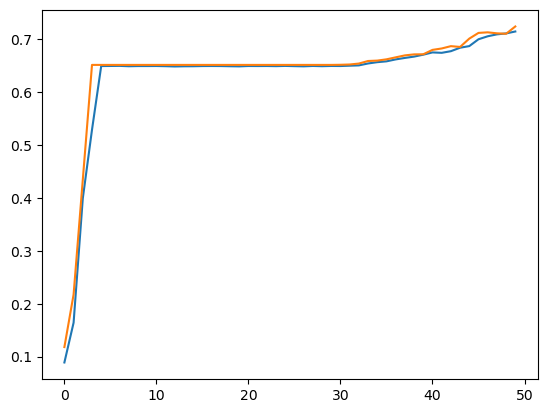

In [65]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])

In [100]:
ids=np.array(df1['id'])
ids

array([1052439, 1130800, 1177330, ..., 1149489, 1025940, 1070083],
      dtype=int64)

In [101]:
n=np.array(model.predict(test_data))

1380/1380 [==============================] - 9s 6ms/step


In [104]:
test_data

array([[  166,    28, 41701, ...,     0,     0,     0],
       [   72,   163, 41701, ...,     0,     0,     0],
       [ 2433,   302, 41701, ...,     0,     0,     0],
       ...,
       [    1, 41701,     0, ...,     0,     0,     0],
       [  364,     7,    86, ...,     0,     0,     0],
       [   33,    54,  1002, ...,     0,     0,     0]])

In [105]:
out={'id':[],'price_value':[],'fake_originality':[],'warranty':[],'size':[],'discrepancy':[],'flavor_odor':[],'expiration_date':[]}

In [106]:
for i in range(len(n)):
    biner=bin(int(float(ohe.get_feature_names_out()[n[i].argmax()][3:])))[2:]
    lab=''
    if len(biner)==7:
        lab=biner
    elif len(biner)<7:
        lab=biner+((7-len(biner))*'0')
    out['id'].append(ids[i])
    out['price_value'].append(int(lab[0]))
    out['fake_originality'].append(int(lab[1]))
    out['warranty'].append(int(lab[2]))
    out['size'].append(int(lab[3]))
    out['discrepancy'].append(int(lab[4]))
    out['flavor_odor'].append(int(lab[5]))
    out['expiration_date'].append(int(lab[6]))

In [108]:
pd.DataFrame(out)

,id,price_value,fake_originality,warranty,size,discrepancy,flavor_odor,expiration_date
0,1052439,0,0,0,0,0,0,0
1,1130800,0,0,0,0,0,0,0
2,1177330,0,0,0,0,0,0,0
3,1047314,1,0,0,0,0,0,0
4,1096710,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
44126,1231557,0,0,0,0,0,0,0
44127,1256361,1,0,0,0,0,0,0
44128,1149489,0,0,0,0,0,0,0
44129,1025940,0,0,0,0,0,0,0


In [115]:
pd.DataFrame(out).to_csv('output.csv')